In [10]:
import pandas as pd
from collections import defaultdict

# Function to get unique pairs from a list of characters
def get_unique_pairs(characters):
    pairs = set()
    for i in range(len(characters)):
        for j in range(i + 1, len(characters)):
            pairs.add(tuple(sorted([characters[i], characters[j]])))
    return pairs

# Load the CSV file into a DataFrame
file_path = 'Game_of_Thrones_Script.csv'
got_df = pd.read_csv(file_path)

# Remove rows where 'Name' is NaN
got_df_cleaned = got_df.dropna(subset=['Name'])

# Preparing a dictionary to hold interactions per season
interactions_per_season = defaultdict(lambda: defaultdict(int))

for i in range(len(got_df_cleaned)):
    current_season = got_df_cleaned.iloc[i]['Season']
    current_speaker = got_df_cleaned.iloc[i]['Name']

    # Next 5 lines or to the end of the dataset
    next_lines = got_df_cleaned.iloc[i+1:i+6]

    # Characters in the current conversation excluding the current speaker
    characters_in_conversation = list(next_lines['Name'].unique())
    if current_speaker in characters_in_conversation:
        characters_in_conversation.remove(current_speaker)

    # Get all unique pairs of characters in this conversation
    pairs = get_unique_pairs(characters_in_conversation)

    # Update the interaction count for each pair
    for pair in pairs:
        interactions_per_season[current_season][pair] += 1

# Convert to DataFrame for easier analysis and visualization
interactions_df = pd.DataFrame([
    {'Season': season, 'Pair': pair, 'Interactions': count}
    for season, pairs in interactions_per_season.items()
    for pair, count in pairs.items()
])

# Displaying a sample of the final DataFrame
interactions_df.sample(10)


,Season,Pair,Interactions
5159,Season 8,"(podrick, tyrion lannister)",2
2891,Season 4,"(jon snow, stannis baratheon)",5
1654,Season 3,"(jon snow, rattleshirt)",3
1494,Season 2,"(joffrey lannister, stannis baratheon)",2
1495,Season 2,"(davos, joffrey lannister)",5
3859,Season 5,"(brother, olly)",3
5303,Season 8,"(edmure, tyrion lannister)",7
520,Season 1,"(greatjon umber, theon greyjoy)",9
2931,Season 4,"(man, oberyn martell)",1
5073,Season 8,"(jaime lannister, tormund)",11


In [11]:
# Filtering the dataframe for Season 1 and sorting by the number of interactions
season_1_interactions = interactions_df[interactions_df['Season'] == 'Season 1']
top_15_interactions_season_1 = season_1_interactions.sort_values(by='Interactions', ascending=False).head(15)

top_15_interactions_season_1


,Season,Pair,Interactions
107,Season 1,"(daenerys targaryen, jorah mormont)",49
66,Season 1,"(eddard stark, robert baratheon)",45
22,Season 1,"(catelyn stark, robb stark)",40
48,Season 1,"(cersei lannister, eddard stark)",39
297,Season 1,"(bronn, tyrion lannister)",37
25,Season 1,"(catelyn stark, eddard stark)",36
21,Season 1,"(eddard stark, sansa stark)",35
63,Season 1,"(arya stark, eddard stark)",35
33,Season 1,"(robb stark, theon greyjoy)",30
68,Season 1,"(arya stark, sansa stark)",30


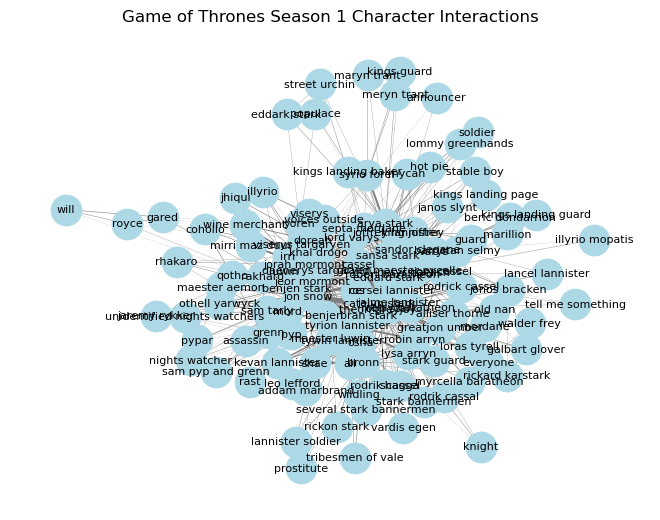

In [14]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a dictionary of graphs, one for each season
season_graphs = {}

for season in interactions_df['Season'].unique():
    # Filter dataframe for the current season
    season_data = interactions_df[interactions_df['Season'] == season]

    # Create a graph for the season
    G = nx.Graph()

    # Add edges with weights
    for _, row in season_data.iterrows():
        G.add_edge(row['Pair'][0], row['Pair'][1], weight=row['Interactions'])

    # Store the graph
    season_graphs[season] = G

# Check the nodes and edges of one of the graphs as a sample, e.g., Season 1
sample_season = 'Season 1'
sample_graph = season_graphs[sample_season]
sample_graph_nodes = list(sample_graph.nodes)
sample_graph_edges = list(sample_graph.edges(data=True))

(sample_graph_nodes[:5], sample_graph_edges[:5])  # Displaying a sample of nodes and edges

# Get the graph for Season 1
season_1_graph = season_graphs['Season 1']

# Create a layout for our nodes 
layout = nx.spring_layout(season_1_graph, seed=42)

# Draw the nodes and the edges (including the width for edges)
nx.draw(season_1_graph, layout, with_labels=True, node_size=500, node_color='lightblue', 
        linewidths=0.5, font_size=8, edge_color='gray', width=[data['weight']*0.1 for _, _, data in season_1_graph.edges(data=True)])

# Show the plot
plt.title("Game of Thrones Season 1 Character Interactions")
plt.show()


In [15]:
import dash
import dash_cytoscape as cyto
from dash import html, dcc, Input, Output
import networkx as nx

# Initialize the Dash app
app = dash.Dash(__name__)

# Function to generate cytoscape elements from a NetworkX graph
def generate_cytoscape_elements(G):
    elements = [{'data': {'id': node, 'label': node}} for node in G.nodes]
    elements += [{'data': {'source': source, 'target': target, 'weight': data['weight']}}
                 for source, target, data in G.edges(data=True)]
    return elements

# App layout
app.layout = html.Div([
    html.H1("Game of Thrones Character Interactions"),
    dcc.Dropdown(
        id='season-selector',
        options=[{'label': season, 'value': season} for season in season_graphs.keys()],
        value='Season 1'
    ),
    cyto.Cytoscape(
        id='got-network',
        elements=generate_cytoscape_elements(season_graphs['Season 1']),
        style={'width': '100%', 'height': '600px'},
        layout={'name': 'circle'}
    )
])

# Callback to update graph based on season selection
@app.callback(
    Output('got-network', 'elements'),
    [Input('season-selector', 'value')]
)
def update_graph(selected_season):
    return generate_cytoscape_elements(season_graphs[selected_season])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
